In [134]:
# import packages
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider
from qiskit import transpile
from math import pi

provider = IonQProvider(token='eHMFfV9o1gffeXCQLlpzKdh1nvoGUT1A')

In [167]:
def intra_finch_evolution(qcircuit, finch_N, theta_i, theta_intra):
    
    characteristics_per_finch = 4
    for ii in range(characteristics_per_finch):
        qubit_N = ii+characteristics_per_finch*finch_N
        qcircuit.rx(theta_i[qubit_N],qubit_N)
        
    qcircuit.rxx(theta_intra[finch_N][0],0+characteristics_per_finch*finch_N, 2+characteristics_per_finch*finch_N)
    qcircuit.rxx(theta_intra[finch_N][1],1+characteristics_per_finch*finch_N, 3+characteristics_per_finch*finch_N)
    qcircuit.rxx(theta_intra[finch_N][2],0+characteristics_per_finch*finch_N, 3+characteristics_per_finch*finch_N)

def inter_finch_evolution(qcircuit, finch_Ns, characteristic, theta_inter):
    
    characteristics_per_finch = 4
    
    for ii in range(len(characteristic)):
        partial_swap(qcircuit, finch_Ns, characteristic[ii], theta_inter[ii])
    
def create_quantum_circuit(theta_i, theta_intra, theta_inter, N_finches=2):
    
    characteristics_per_finch = 4
    
    finch_evolution = QuantumCircuit(N_finches*characteristics_per_finch,N_finches*characteristics_per_finch)
    
    for ii in range(N_finches):
        intra_finch_evolution(finch_evolution, ii, theta_i, theta_intra)
        
        
    inter_finch_evolution(finch_evolution, [0,1], [0,3], theta_inter)
    
    finch_evolution.measure(range(characteristics_per_finch*N_finches), range(characteristics_per_finch*N_finches))  
    
    return finch_evolution

def partial_swap(qcircuit, finch_Ns, characteristic, theta_inter):
    
    characteristics_per_finch = 4
    
    qcircuit.crx(pi, characteristic+finch_Ns[0]*characteristics_per_finch, 
                      characteristic+finch_Ns[1]*characteristics_per_finch)
    
    qcircuit.crx(theta_inter, characteristic+finch_Ns[1]*characteristics_per_finch, 
                      characteristic+finch_Ns[0]*characteristics_per_finch)
    
    qcircuit.crx(pi, characteristic+finch_Ns[0]*characteristics_per_finch, 
                      characteristic+finch_Ns[1]*characteristics_per_finch)
    

In [168]:
theta_i = [pi,pi,pi,pi,pi/2,pi/2,pi/2,pi/2]
theta_intra = [[pi/10,pi/10,pi/10],[pi/10,pi/10,pi/10]]
theta_inter = [pi/4, pi/4]


circuit = create_quantum_circuit(theta_i, theta_intra, theta_inter, N_finches=2)

In [169]:
# view list of available backends
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

In [170]:
# load backend by using the get_backend method
backend = provider.get_backend("ionq_simulator")

In [171]:
transpiled = transpile(circuit, backend)
print(transpiled)

      ┌───────┐ ┌────────────┐              ┌────────────┐               »
q_0: ─┤ Rx(π) ├─┤0           ├──────────────┤0           ├──────────■────»
      ├───────┤ │            │┌────────────┐│            │┌─┐       │    »
q_1: ─┤ Rx(π) ├─┤  Rxx(π/10) ├┤0           ├┤            ├┤M├───────┼────»
      ├───────┤ │            ││            ││  Rxx(π/10) │└╥┘┌─┐    │    »
q_2: ─┤ Rx(π) ├─┤1           ├┤  Rxx(π/10) ├┤            ├─╫─┤M├────┼────»
      ├───────┤ └────────────┘│            ││            │ ║ └╥┘    │    »
q_3: ─┤ Rx(π) ├───────────────┤1           ├┤1           ├─╫──╫─────┼────»
     ┌┴───────┴┐┌────────────┐└────────────┘├────────────┤ ║  ║ ┌───┴───┐»
q_4: ┤ Rx(π/2) ├┤0           ├──────────────┤0           ├─╫──╫─┤ Rx(π) ├»
     ├─────────┤│            │┌────────────┐│            │ ║  ║ └──┬─┬──┘»
q_5: ┤ Rx(π/2) ├┤  Rxx(π/10) ├┤0           ├┤            ├─╫──╫────┤M├───»
     ├─────────┤│            ││            ││  Rxx(π/10) │ ║  ║    └╥┘   »
q_6: ┤ Rx(π/2) ├┤1       

In [172]:
# submit the circuit

job = backend.run(circuit)

In [173]:
result = job.result()

In [174]:
#get counts
counts = result.get_counts()

In [202]:
def characteristic_results_from_outcome(counts,shots,finch_N=2):
    
    characteristics_per_finch = 4
    characteristic_results = np.zeros(finch_N*characteristics_per_finch)

    for kk in range(len(characteristic_results)):
        for ii in range(2**(len(characteristic_results)-1)):
            string = np.binary_repr(ii,width=(len(characteristic_results)-1))[:kk]+str(1)+np.binary_repr(ii,width=(len(characteristic_results)-1))[kk:]
            if string in counts:
                characteristic_results[kk] += counts[string]
                
    return characteristic_results/shots
 

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'color finch 1'),
  Text(1, 0, 'beak size finch 1'),
  Text(2, 0, 'wingspan finch 1'),
  Text(3, 0, 'fatness finch 1'),
  Text(4, 0, 'color finch 2'),
  Text(5, 0, 'beak size finch 2'),
  Text(6, 0, 'wingspan finch 2'),
  Text(7, 0, 'fatness finch 2')])

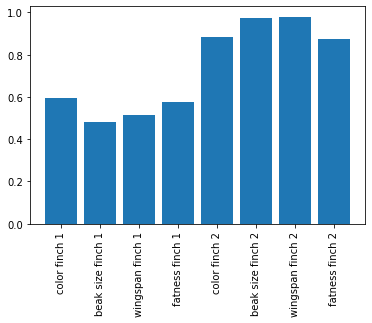

In [176]:
import matplotlib.pyplot as plt

characteristic_results = characteristic_results_from_outcome(counts,finch_N=2)
                    
plt.bar(['color finch 1','beak size finch 1','wingspan finch 1','fatness finch 1',
        'color finch 2','beak size finch 2','wingspan finch 2','fatness finch 2'], characteristic_results)

plt.xticks(rotation=90)

In [203]:
def theta_is_from_outcome(characteristic_results):
    theta_i = np.arccos(np.sqrt(characteristic_results))
    return 2*theta_i

In [204]:
def natural_selection_modifier(theta_i, preferred_characteristics, multiplier):
    return multiplier*(pi*preferred_characteristics-theta_i) + theta_i

In [147]:
characteristic_results = characteristic_results_from_outcome(counts,finch_N=2)

In [148]:
theta_i = theta_is_from_outcome(characteristic_results)

preferred_characteristics = np.array([0,0,0,0,0,1,1,1,1,1])
multiplier = np.array([1,1,1,1,1,1,1,1,1,1])

theta_i = natural_selection_modifier(theta_i, preferred_characteristics, multiplier)

In [149]:
#theta_intra = [[0,0,0],[pi,pi,pi]]
theta_intra = [[pi/10,pi/10,pi/10],[pi/10,pi/10,pi/10]]
theta_inter = [pi/4, pi/4]


circuit = create_quantum_circuit(theta_i, theta_intra, theta_inter, N_finches=2)

In [198]:
job = backend.run(circuit, shots=50)
result = job.result()
counts = result.get_counts()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'color finch 1'),
  Text(1, 0, 'beak size finch 1'),
  Text(2, 0, 'wingspan finch 1'),
  Text(3, 0, 'fatness finch 1'),
  Text(4, 0, 'color finch 2'),
  Text(5, 0, 'beak size finch 2'),
  Text(6, 0, 'wingspan finch 2'),
  Text(7, 0, 'fatness finch 2')])

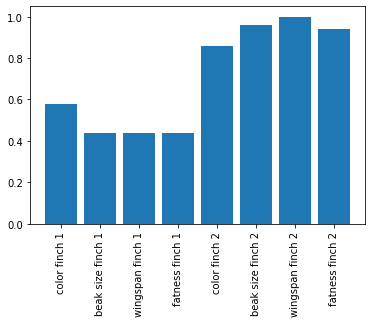

In [201]:
characteristic_results = characteristic_results_from_outcome(counts,finch_N=2)
                    
plt.bar(['color finch 1','beak size finch 1','wingspan finch 1','fatness finch 1',
        'color finch 2','beak size finch 2','wingspan finch 2','fatness finch 2'], characteristic_results/50)

plt.xticks(rotation=90)

In [210]:
def multi_generation_evolution(N_gen, theta_i, theta_intra, preferred_characteristics, multiplier, shots, N_finches=2):
    
    plt.subplot(N_gen+1,1,1)
                    
    plt.bar(['color finch 1','beak size finch 1','wingspan finch 1','fatness finch 1',
            'color finch 2','beak size finch 2','wingspan finch 2','fatness finch 2'], np.sin(theta_i[::-1]/2)**2)

    plt.xticks(rotation=90)

    plt.ylabel('Gen 0')
        
    for generation in range(N_gen):
        
        circuit = create_quantum_circuit(theta_i, theta_intra, theta_inter, N_finches)
        
        job = backend.run(circuit, shots=50)
        result = job.result()
        counts = result.get_counts()
        
        characteristic_results = characteristic_results_from_outcome(counts,shots,finch_N=2)
        
        theta_i = theta_is_from_outcome(characteristic_results)

        theta_i = natural_selection_modifier(theta_i, preferred_characteristics, multiplier)
        
        plt.subplot(N_gen+1,1,generation+2)
                    
        plt.bar(['color finch 1','beak size finch 1','wingspan finch 1','fatness finch 1',
                'color finch 2','beak size finch 2','wingspan finch 2','fatness finch 2'], characteristic_results)

        plt.xticks(rotation=90)
        
        plt.ylabel('Gen ' + str(generation+1))
        
    plt.show()
    

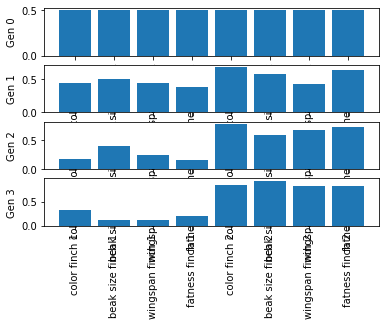

In [211]:
N_gen = 3

theta_i = np.array([pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2])
theta_intra = [[pi/10,pi/10,pi/10],[pi/10,pi/10,pi/10]]
theta_inter = [pi/4, pi/4]

preferred_characteristics = np.array([1,1,1,1,0,0,0,0])
multiplier = 0.3*np.array([1,1,1,1,1,1,1,1])

shots = 50

multi_generation_evolution(N_gen, theta_i, theta_intra, preferred_characteristics, multiplier, shots, N_finches=2)




